In [36]:
import joblib

In [7]:
#Scaler
df = pd.read_csv("amman_Ready.csv")
df['time'] = pd.to_datetime(df['Unnamed: 0'])
df.set_index('time', inplace=True)
df.drop(['Unnamed: 0'], axis=1, inplace=True)

# Cyclical features
df['day'] = df.index.day
df['month'] = df.index.month
df['hour'] = df.index.hour
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df.drop(['day', 'month', 'hour'], axis=1, inplace=True)

# Define features and targets
features = ['Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
            'Atmospheric Pressure', 'Wind_U', 'Wind_V']
cyclical = ['day_cos', 'day_sin', 'month_cos', 'month_sin', 'hour_cos', 'hour_sin']
all_features = features + cyclical

# Standardize all inputs
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[all_features])

In [5]:
joblib.dump(scaler, "amman_scaler.pkl")

NameError: name 'joblib' is not defined

C:\Users\20210291\AppData\Local\Temp\ipykernel_34272\1888096719.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"patchtst_{target_feat

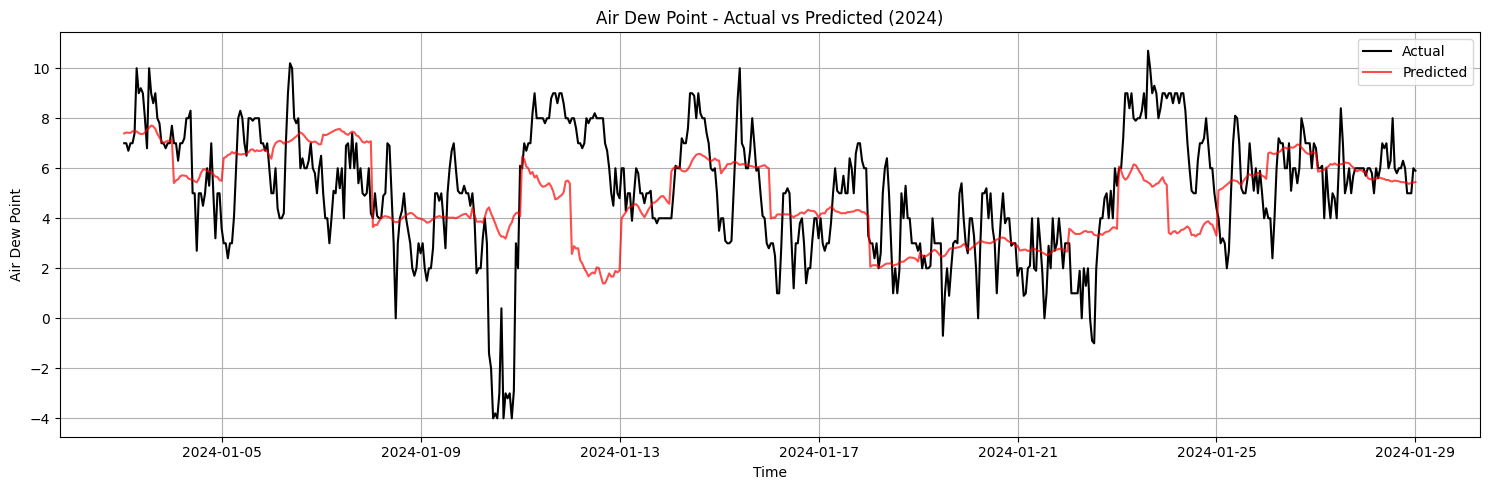

In [8]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from transformers import PatchTSTForPrediction, PatchTSTConfig

# ----------------------------------------
# Parameters (keep consistent with training)
# ----------------------------------------
input_len = 72
output_len = 24
device = "cuda" if torch.cuda.is_available() else "cpu"
target_feature = 'Air Dew Point'  # You can change this

# ----------------------------------------
# Load and preprocess test set
# ----------------------------------------
test_df = pd.read_csv("amman_test.csv")
test_df['time'] = pd.to_datetime(test_df['Unnamed: 0'])
test_df = test_df.set_index(test_df['time']).drop(columns=['Unnamed: 0', 'time'])

# Filter for 2024


# Use same features as training
test_df['day'] = test_df.index.day
test_df['month'] = test_df.index.month
test_df['hour'] = test_df.index.hour
test_df['day_cos'] = np.cos(2 * np.pi * test_df['day'] / 31)
test_df['day_sin'] = np.sin(2 * np.pi * test_df['day'] / 31)
test_df['month_cos'] = np.cos(2 * np.pi * test_df['month'] / 12)
test_df['month_sin'] = np.sin(2 * np.pi * test_df['month'] / 12)
test_df['hour_cos'] = np.cos(2 * np.pi * test_df['hour'] / 24)
test_df['hour_sin'] = np.sin(2 * np.pi * test_df['hour'] / 24)
test_df.drop(['day', 'month', 'hour'], axis=1, inplace=True)
# Scale using training scaler
test_scaled = scaler.transform(test_df[all_features])
test_scaled = pd.DataFrame(test_scaled, columns=all_features, index=test_df.index)
test_scaled = test_scaled[(test_scaled.index > pd.to_datetime('2024-01-01'))
    & (test_scaled.index < pd.to_datetime('2024-01-31'))]
# ----------------------------------------
# Load trained model
# ----------------------------------------
config = PatchTSTConfig(
    context_length=input_len,
    prediction_length=output_len,
    patch_len=24,
    stride=8,
    d_model=128,
    n_heads=8,
    num_encoder_layers=3,
    dropout=0.1,
    head_dropout=0.1,
    num_input_channels=len(all_features),
    num_targets=1,
    scaling="std",
)
model = PatchTSTForPrediction(config).to(device)
model.load_state_dict(torch.load(f"patchtst_{target_feature.replace(' ', '_')}.pt"))
model.eval()

# ----------------------------------------
# Run sliding window inference
# ----------------------------------------
inputs = test_scaled[all_features].values
target_actual = test_df[target_feature].values

predictions = []
actuals = []
timestamps = []

for i in range(input_len, len(inputs) - output_len + 1, output_len):
    x = inputs[i - input_len:i]  # shape: [72, 12]
    y_true = target_actual[i:i + output_len]  # actual future values

    x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)  # shape: [1, 72, 12]
    with torch.no_grad():
        y_pred = model(x_tensor).prediction_outputs.squeeze(0).cpu().numpy()  # shape: (24, 12)

    # ✅ Extract only target feature
    y_pred_single = y_pred[:, all_features.index(target_feature)]  # (24,)
    
    # ✅ Inverse scale using dummy vector
    y_pred_full = np.zeros((output_len, len(all_features)))
    y_pred_full[:, all_features.index(target_feature)] = y_pred_single
    y_pred_unscaled = scaler.inverse_transform(y_pred_full)[:, all_features.index(target_feature)]

    predictions.extend(y_pred_unscaled)
    actuals.extend(y_true)
    timestamps.extend(test_df.index[i:i + output_len])

# ----------------------------------------
# Plot results
# ----------------------------------------
plt.figure(figsize=(15, 5))
plt.plot(timestamps, actuals, label='Actual', color='black', linewidth=1.5)
plt.plot(timestamps, predictions, label='Predicted', color='red', alpha=0.7)
plt.title(f'{target_feature} - Actual vs Predicted (2024)')
plt.xlabel('Time')
plt.ylabel(target_feature)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
y_pred.shape

(24, 12)